# Logistic Regression using Iris dataset
The Iris flower data set or Fisher's Iris data set is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper *The Use of Multiple Measurements in Taxonomic Problems* as an example of linear discriminant analysis.

Linear regression is used to make predictions for continuous variables, while logistic regression is used to make predictions for discrete variables (ie as a classifier).

### Preparations

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Logistic regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
# Load Iris.csv as a dataframe
df = pd.read_csv('Iris.csv')

### Data familiarisation

In [3]:
# Shape
df.shape

(150, 6)

In [4]:
# Columns
df.columns

Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

In [5]:
# Display sample data
df.sample(6)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
79,80,5.7,2.6,3.5,1.0,Iris-versicolor
31,32,5.4,3.4,1.5,0.4,Iris-setosa
73,74,6.1,2.8,4.7,1.2,Iris-versicolor
19,20,5.1,3.8,1.5,0.3,Iris-setosa
71,72,6.1,2.8,4.0,1.3,Iris-versicolor
30,31,4.8,3.1,1.6,0.2,Iris-setosa


In [6]:
# Descriptive statistics for numerical columns
df.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


### Data cleansing

In [7]:
# Check for duplicates
# Display starting rows
starting_rows = df.shape[0]
print(f"There are {starting_rows} rows, including any duplicates.")

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Confirm operation
print(f"{starting_rows - df.shape[0]} duplicate rows were found and removed.")

There are 150 rows, including any duplicates.
0 duplicate rows were found and removed.


In [8]:
# Check column dtypes and count null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


No duplicates, no null values and no issues with dtype found. The data is ready for analysis.
### Exploratory data analysis

In [9]:
# Remove Id column since Id = index + 1
df.drop(['Id'], axis=1, inplace=True)

<Axes: >

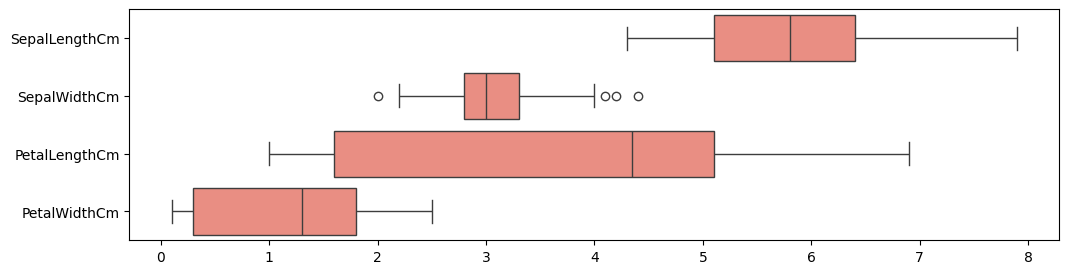

In [10]:
# Boxplots of continuous variables to check for outliers

# Prepare figure
fig = plt.figure(figsize=(12,3))

# Create boxplot
sns.boxplot(
    data=df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']],
    orient='h', color='salmon'
)

SepalWidthCm contains outliers, according to the seaborn boxplot. Check the population distributions of the variables for confirmation.

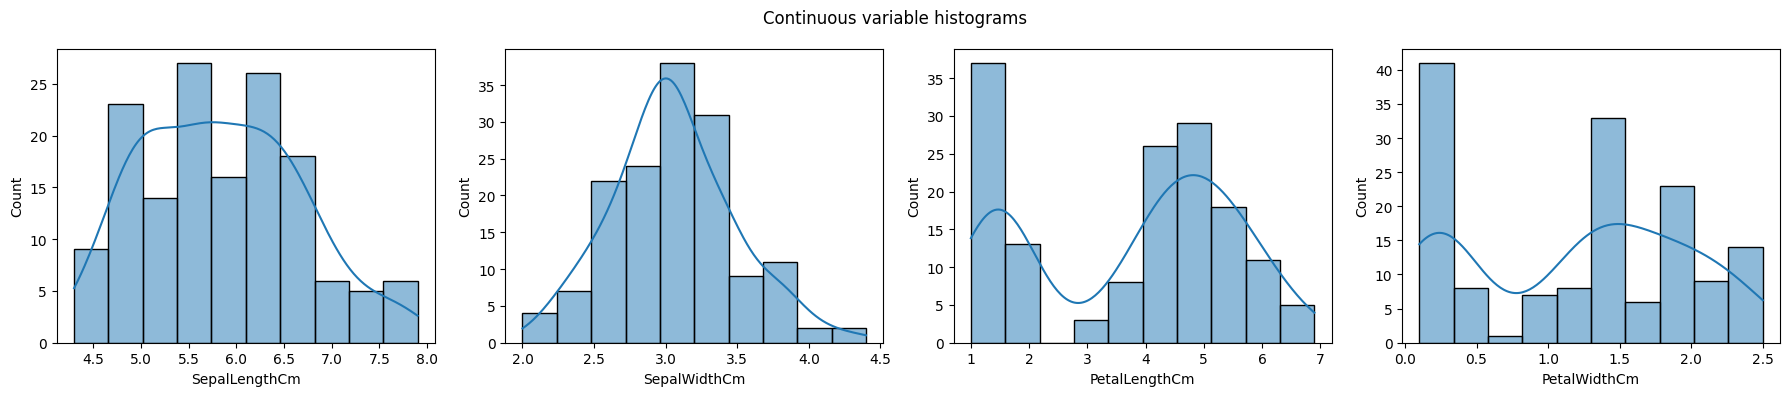

In [11]:
# View the continuous variable distributions

# Prepare figure
fig, axes = plt.subplots(1, 4, figsize=(18,4))

# Create histograms
bins = 10
sns.histplot(data=df, x='SepalLengthCm', ax=axes[0], kde=True, bins=bins)
sns.histplot(data=df, x='SepalWidthCm', ax=axes[1], kde=True, bins=bins)
sns.histplot(data=df, x='PetalLengthCm', ax=axes[2], kde=True, bins=bins)
sns.histplot(data=df, x='PetalWidthCm', ax=axes[3], kde=True, bins=bins)

# Add title
fig.suptitle(f'Continuous variable histograms')

# Display
plt.tight_layout()

SepalLengthCm and SepalWidthCm are normally distributed. The SepalWidthCm distribution is extended to both high and low values, which registered as outliers in the boxplot. However, the distribution is continuous and it seems likely the outliers aren't influential. If the model is poor, I will revisit the the outliers. 

PetalLengthCm and PetalWidthCm are both bimodal distributions. 

Overall, I find no indication of outliers in the data.

In [12]:
# Investigate Species
df['Species'].value_counts()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

The dataset is divided equally between the species categories.

# Develop classifier
The goal is to develop a classifier that can determine whether a given iris flower belongs to the Iris-setosa class or not.

## Identify independent variables x

In [13]:
# Independent variables x are SepalLengthCm, SepalWidthCm, PetalLengthCm and
# PetalWidthCm ie all columns except Species
X = df.drop(['Species'], axis=1)

# Convert X dataframe to numpy array
X = X.to_numpy()

## Encode the dependent variable y
Encode the dependent variable y such that Iris-setosa is encoded as 0, and Iris-versicolour and Iris-virginica are both encoded as 1. Here, 0 corresponds to the Iris-setosa class, and 1 corresponds to the not-Iris-setosa class.

In [14]:
# Dependent variable y is derived from Species
# Create new column Setosa with default value 0
df['Setosa'] = 0

# Find rows where Species = Iris_Setosa and set Setosa to 1
df.loc[(df['Species'] == 'Iris-setosa'), 'Setosa'] = 1

In [15]:
# Separate the dependent (target) variable
y = df['Setosa'].to_numpy()

## Split the data

In [16]:
# Reshape X
X = X.reshape(-1, 4)

# Create a training and test set with a 75:25 split ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.25, 
    shuffle=True
)

### Standardize X_train and X_test
The distributions are approximately Gaussian, so the most appropriate method for scaling the data is StandardScaler.

In [17]:
# Prepare scaler
scaler=StandardScaler()

# Apply to X_train
X_train_std = scaler.fit_transform(X_train)

# Apply the same transformation to X_test
X_test_std = scaler.transform(X_test)

## Create logistic regression model

In [18]:
# Fit a logistic regression model to X_train_std
log_reg = LogisticRegression()
log_reg.fit(X_train_std, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [19]:
# Predictions from X_test_std
y_pred = log_reg.predict(X_test_std).reshape(-1,1)

## Confusion matrix

In [20]:
# Create a list of class names from the original dataset (df)
classes = ['Setosa', 'Not Setosa']

# Generate a confusion matrix using true labels (y_test) and predicted labels
# (y_pred)
confusion = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix into a dataframe
cfm_df = pd.DataFrame(confusion, columns=classes, index=classes)
cfm_df

,Setosa,Not Setosa
Setosa,23,0
Not Setosa,0,15


The confusion matrix summarises the predictions. The rows are the true or gold labels (y_test) and the columns are the predicted labels (y_pred). The values on the NW-SE diagonal show the successes. The off-diagonal values show the cases where the model prediction is wrong, representing false positives, or type I errors, in the NE quadrant and false negatives, or type II errors, in the SW quadrant.

For this dataset, there are no errors in the model.

<b>Precision</b> is the proportion of predictions of the positive class that are correct and <b>recall</b> is how many instances of a class the model recognised. For this model, the precision and accuracy should be same and should be equal to 1 since there are neither false positives not false negatives.

## Manual code to calculate accuracy, precision and recall

Definitions:
> accuracy = (TP + TN) / (TP + FP + TN + FN)

> precision = TP / (TP + FP)

> recall = TP / (TP + FN)

where:
* TP = number of true positives ie top left quadrant in the confusion matrix
* FP = number of false positives ie top right quadrant
* TN = number of true negatives ie bottom right quadrant
* FN = number of false negatives ie bottom left quadrant

In [21]:
# Find TP, FP, TN, FN
TP = cfm_df.iat[0, 0]
FP = cfm_df.iat[0, 1]
TN = cfm_df.iat[1, 1]
FN = cfm_df.iat[1, 0]

print(f"TP = {TP}, FP = {FP}, TN = {TN}, FN = {FN}")

TP = 23, FP = 0, TN = 15, FN = 0


In [22]:
# Code for accuracy
accuracy = (TP + TN) / (TP + FP + TN + FN)

print(f"The accuracy is {accuracy}.")

The accuracy is 1.0.


In [23]:
# Code for precision
precision = TP / (TP + FP)

print(f"The precision is {precision}.")

The precision is 1.0.


In [24]:
# Code for recall
recall = TP / (TP + FN)

print(f"The recall is {recall}.")

The recall is 1.0.


The above method works for a 2x2 confusion matrix (ie the binary case). Write a function to extend the method to an nxn confusion matrix.

In [25]:
# Combine all these into a function
def APR(confusion_matrix, req_cl):
    '''
    Function takes an n*n confusion matrix and outputs accuracy, precision and
    recall.    
    list [accuracy, 
    precision, recall] for the required class, req_cl.
    Parameters:
        confusion_matrix = confusion matrix of y_test and y_pred as DataFrame
        req_cl = column name as string
    Output:
        APR_list = [accuracy, precision, recall]   
    '''
    # Find the index of the required class
    cl_pos = confusion_matrix.columns.get_loc(req_cl)

    # Find TP
    TP = confusion_matrix.iat[cl_pos, cl_pos]

    # Find FP = sum of TP column except TP
    FP = 0
    for j in range(confusion_matrix.shape[0]):
        FP += confusion_matrix.iat[cl_pos, j]
    FP -= TP

    # Find FN = sum of TP row except TP
    FN = 0
    for i in range(confusion_matrix.shape[1]):
        FN += confusion_matrix.iat[i, cl_pos]
    FN -= TP

    # Find TN
    TN = 0
    for i in range(confusion_matrix.shape[1]):
        for j in range(confusion_matrix.shape[0]):
            TN += confusion_matrix.iat[i, j]
    TN -= TP - FP - FN

    # Create empty list
    APR_list = ['','','']

    # Calculate accuracy
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    APR_list[0] = accuracy

    # Calculate precision
    precision = TP / (TP + FP)
    APR_list[1] = precision
    
    # Calculate recall
    recall = TP / (TP + FN)
    APR_list[2] = recall

    return APR_list

In [26]:
# Test the function
list = APR(cfm_df, 'Setosa')

# Display output
print(
    f"Using my APR function:\n     accuracy = {list[0]}\n    precision = "
    f"{list[1]}\n       recall = {list[2]}"
)

Using my APR function:
     accuracy = 1.0
    precision = 1.0
       recall = 1.0


## Use sklearn functions to find accuracy, precision and recall

In [27]:
# Using sklearn score functions:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(
    f"Using sklearn functions:\n     accuracy = {accuracy}\n    precision = "
    f"{precision}\n       recall = {recall}"
)

Using sklearn functions:
     accuracy = 1.0
    precision = 1.0
       recall = 1.0


The output of my code agrees with sklearn.

## Extension to multiclass case

In [28]:
# Separate the dependent variable
yO_temp = df['Species'].to_numpy()

# Create empty array of the same size
yO = np.empty(len(yO_temp))

# Populate yO with Iris-setosa = 0, Iris-versicolor = 1, Iris-virginica = 2
for i in range (len(yO_temp)):
    if yO_temp[i] == 'Iris-setosa':
        yO[i] = 0
    elif yO_temp[i] == 'Iris-versicolor':
        yO[i] = 1
    else:
        yO[i] = 2

In [29]:
# Reshape X
X = X.reshape(-1, 4)

# Create a training and test set with a 75:25 split ratio
XO_train, XO_test, yO_train, yO_test = train_test_split(
    X, yO, 
    test_size = 0.25, 
    shuffle=True
)

In [30]:
# Apply StandardScaler() to XO_train
scaler=StandardScaler()
XO_train_std = scaler.fit_transform(XO_train)

# Apply the same transformation to XO_test
XO_test_std = scaler.transform(XO_test)

In [31]:
# Fit a logistic regression model to XO_train_std
log_reg = LogisticRegression()
log_reg.fit(XO_train_std, yO_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [32]:
# Predictions from XO_test_std
yO_pred = log_reg.predict(XO_test_std).reshape(-1,1)

In [33]:
# Create a list of class names from the original dataset (df)
classes = ['Setosa', 'Veriscolor', 'Virginica']

# Generate a confusion matrix using true labels (yO_test) and predicted labels (yO_pred)
confusionO = confusion_matrix(yO_test, yO_pred)

# Convert the confusion matrix into a dataframe
cfm_dfO = pd.DataFrame(confusionO, columns=classes, index=classes)
cfm_dfO

,Setosa,Veriscolor,Virginica
Setosa,15,0,0
Veriscolor,0,12,0
Virginica,0,1,10


We can now see the model isn't perfect and has difficulty distinguishing versicolor and viriginica in some cases (the Virginica, Versicolor entry is non-zero).